In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from tensorflow.keras.optimizers import RMSprop

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
import string
import numpy as np
import pandas as pd

import os
import sys
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras.utils as ku
import keras.layers as kl
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from keras.initializers import Constant
from tensorflow.keras.preprocessing.sequence import pad_sequences


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

#from keras.models import Sequential
from tensorflow.keras.layers import Embedding, Activation, Dense, LSTM, Conv2D, Reshape, dot, Lambda, Dropout, MaxPooling2D
from keras.optimizers import SGD
from itertools import islice
from tensorflow.keras.layers import Flatten
from keras.models import model_from_json
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.sequence import TimeseriesGenerator


from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import math
import random
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, EarlyStopping
from datetime import *
from tensorflow.keras import optimizers
from keras.backend import int_shape
pd.set_option('display.max_colwidth',25)
from keras import backend as K
#from tensorflow.keras.layers import concatenate
#K.clear_session()

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import pathlib
rando_seed = 1234
np.random.seed(rando_seed)
#os.chdir('/media/alex/easystore/ids_monthly/BLM_images/2014_11_12')
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

2022-09-29 16:27:46.017858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-09-29 16:27:46.017884: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
# Define class_balance function; assumes that input data has a 'race_category'

def class_balance(dat):
    classes_white = dat[dat['race_category'] == 'W']
    classes_nonwhite = dat[dat['race_category'] == 'NW']

    # Print initial sizes
    print(f'Class White before balance: {len(classes_white)}')
    print(f'Class Non-White before balance: {len(classes_nonwhite)}')    

    # Sample non-whites s.t. that n is equal to whites
    classes_nonwhite = classes_nonwhite.sample(len(classes_white), random_state = rando_seed)
    class_frames = [classes_white, classes_nonwhite]
    new_dat = pd.concat(class_frames)

    # Shuffle data
    new_dat = new_dat.sample(frac=1, random_state=rando_seed).reset_index(drop=True)
    
    print(new_dat.groupby('race_category').count())
    
    return new_dat
    

In [ ]:
def new_balance(dat, z, samp_method, majority_class):
    # z is always the proportion of the overall sample that consists of non-white (NW) observations
    
    classes_white = dat[dat['race_category'] == 'W']
    classes_nonwhite = dat[dat['race_category'] == 'NW']
    
    if z <= .5:
        print(f'Error: your proportion {z} does not represent a majority of the sample...')
        
    else:

        total_n = len(dat)

        minority_prop = (1-z)  

        if samp_method == 'RUS' and majority_class == 'W':
            # undersampling: remove obs 
            print(f'Majority class: white. Undersampling observations from non-white observations...')

            majority_n = len(classes_white)
            new_total_n = int(majority_n / z)
            minority_n = new_total_n - majority_n

            classes_nonwhite = classes_nonwhite.sample(minority_n, replace = False, random_state = rando_seed)

        elif samp_method == 'RUS' and majority_class == 'NW':
            # undersampling: remove obs 
            print(f'Majority class: non-white. Undersampling observations from white observations...')

            majority_n = len(classes_nonwhite)
            new_total_n = int(majority_n / z)
            minority_n = new_total_n - majority_n

            classes_white = classes_white.sample(minority_n, replace = False, random_state = rando_seed)


        elif samp_method == 'ROS' and majority_class == 'W':
            # oversampling: artificially add obs 
            print(f'Majority class: white. Oversampling observations from white observations...')


            nw_n = len(classes_nonwhite)
            new_total_n = int(nw_n / minority_prop)
            w_n = new_total_n - nw_n

            classes_white = classes_white.sample(w_n, replace = True, random_state = rando_seed)

        elif samp_method == 'ROS' and majority_class == 'NW':
            # oversampling: artificially add obs
            print(f'Majority class: non-white. Oversampling observations from non-white observations...')

            w_n = len(classes_white)
            new_total_n = int(w_n / minority_prop)
            nw_n = new_total_n - w_n

            classes_nonwhite = classes_nonwhite.sample(nw_n, replace = True, random_state = rando_seed)

        class_frames = [classes_white, classes_nonwhite]
        new_dat = pd.concat(class_frames)

        # Shuffle data
        new_dat = new_dat.sample(frac=1, random_state=rando_seed).reset_index(drop=True)
        
        classes_white = new_dat[new_dat['race_category'] == 'W']
        classes_nonwhite = new_dat[new_dat['race_category'] == 'NW']
        
        new_white_n = len(classes_white)
        new_nonwhite_n = len(classes_nonwhite)
        new_totes_n = len(new_dat)
        
        white_prop = new_white_n / new_totes_n
        
        nonwhite_prop = new_nonwhite_n / new_totes_n
        
        print(new_dat.groupby('race_category').count())

        print(f'Proportion of total sample that is white: {white_prop}')
        print(f'Proportion of total sample that is non-white: {nonwhite_prop}')
        
        return new_dat

In [ ]:
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_test, y_pred)


In [5]:
dat_name = input("What data set are we working with? ")
print(f"Loading {dat_name} data")

#morph_dat = pd.read_csv('./morph2/morph_2008_nonCommercial.csv')
if dat_name == 'morph':
    
    # Load training data
    train_dat = pd.read_csv('morph_path_index.csv')
    
     
    # Specify data locations
    train_dat_location = '/home/ajpineda/morph2/Album2'
    val_dat_location = '/home/ajpineda/morph2/Album2'
    test_dat_location = '/home/ajpineda/morph2/Album2'
    
    # Specify cross-validation proportions
    train_dat_n = len(train_dat)
    test_dat_n = int(.2 * train_dat_n)
    val_dat_n = int(.2 * train_dat_n)
    
    #### Splitting data into train/test/validate ###

    # Shuffle data
    
    train_dat = train_dat.sample(frac=1, random_state=rando_seed).reset_index(drop=True)


    # Test data (set aside for final model)
    test_dat = train_dat.sample(n = test_dat_n, replace=False, weights=None, random_state=rando_seed, axis=None)
    
    train_dat = train_dat.drop(test_dat.index)
    # test_dat.head()
    test_dat_n = len(test_dat)
    print(f"There are {test_dat_n} observations in the test set")
    
    
    # Validation data (used for parameter tuning)
    val_dat = train_dat.sample(n = val_dat_n, replace=False, weights=None, random_state=rando_seed, axis=None)
    train_dat = train_dat.drop(val_dat.index)
    val_dat_n = len(val_dat)
    print(f"There are {val_dat_n} observations in the validation set")
    
    train_dat_n = len(train_dat)
    print(f"There are {train_dat_n} observations in the training set")

    train_dat.head()
else:
    
    # Load train and validation data
    train_dat = pd.read_csv('/home/ajpineda/fair_face/fairface_label_train.csv')
    val_dat = pd.read_csv('/home/ajpineda/fair_face/fairface_label_val.csv')
          
    #  Specify data locations
    train_dat_location = 'home/ajpineda/fair_face/train'
    val_dat_location = 'home/ajpineda/fair_face/val'
    test_dat_location = 'home/ajpineda/fair_face/train'
          
    #  Specify number of observations in test data
    train_dat_n = len(train_dat)
    test_dat_n = int(.2 * train_dat_n)
    val_dat_n = len(val_dat)
          
    #### Splitting data into train/test/validate ###

    # Shuffle data
    
    train_dat = train_dat.sample(frac=1, random_state=rando_seed).reset_index(drop=True)


    # Test data (set aside for final model)
    test_dat = train_dat.sample(n = test_dat_n, replace=False, weights=None, random_state=rando_seed, axis=None)
    train_dat = train_dat.drop(test_dat.index)
    # test_dat.head()
          
    test_dat_n = len(test_dat)
    print(f"There are {test_dat_n} observations in the test set")
    
    print(f"There are {val_dat_n} observations in the validation set")
          
    train_dat_n = len(train_dat)
    print(f"There are {train_dat_n} observations in the training set")
    
    fair_face_dats = [train_dat, test_dat, val_dat]
    
    for dats in fair_face_dats:
        # Create the dictionary
        race_dict ={'White' : 'W', 'Black' : 'NW', 'East Asian' : 'NW', 'Latino_Hispanic':'NW', 
                    'Southeast Asian':'NW', 'Indian': 'NW', 'Middle Eastern': 'NW', }
  
        # Add a new column named 'race_cat'
        dats['race_category'] = dats['race'].map(race_dict)
        
        dats.rename(columns={"file": "file_name"}, inplace = True)
        
        location = '/home/ajpineda/fair_face'
        
        
        dats["full_path"] = dats[['file_name']].apply(
            lambda x:pathlib.Path(
                r"/home/ajpineda/fair_face/{}".format(
                    x['file_name']
                )
            ),
            axis=1
        )
        
        dats['full_path'] = dats['full_path'].astype(str)
        
       

What data set are we working with?  morph


Loading morph data
There are 11026 observations in the test set
There are 11026 observations in the validation set
There are 33082 observations in the training set


In [6]:
balance = input("Do you want balanced data sets? ")


if balance == 'yes':
    train_dat = class_balance(train_dat)
    val_dat = class_balance(val_dat)
    test_dat = class_balance(test_dat)



Do you want balanced data sets?  yes


Class White before balance: 6311
Class Non-White before balance: 26771
               id_num  picture_num   dob   doa  race  gender  facial_hair  \
race_category                                                               
NW               6311         6311  6311  6311  6311    6311            0   
W                6311         6311  6311  6311  6311    6311            0   

                age  age_diff  glasses  file_name  full_path  
race_category                                                 
NW             6311      4757        0       6311       6311  
W              6311      4715        0       6311       6311  
Class White before balance: 2148
Class Non-White before balance: 8878
               id_num  picture_num   dob   doa  race  gender  facial_hair  \
race_category                                                               
NW               2148         2148  2148  2148  2148    2148            0   
W                2148         2148  2148  2148  2148    2148       

In [ ]:
"""
dat = train_dat
prop = .9
prop_f = 9
samp_method = 'ROS'
majority_class = 'W'
"""



In [ ]:


#new_train_dat = new_balance(dat, prop, samp_method, majority_class)

In [8]:
train_dat.race.value_counts()

W    6311
B    6005
H     267
A      24
O      15
Name: race, dtype: int64

In [10]:
train_dat.dtypes

id_num             int64
picture_num        int64
dob               object
doa               object
race              object
gender            object
facial_hair      float64
age                int64
age_diff         float64
glasses          float64
file_name         object
race_category     object
full_path         object
dtype: object

In [ ]:
#import os.path
#from os import path


#morph_dat = morph_dat[[path.exists(i) for i in morph_dat['full_path']]]

In [11]:
train_dat.groupby('race_category').count()

,id_num,picture_num,dob,doa,race,gender,facial_hair,age,age_diff,glasses,file_name,full_path
race_category,,,,,,,,,,,,
NW,6311,6311,6311,6311,6311,6311,0,6311,4757,0,6311,6311
W,6311,6311,6311,6311,6311,6311,0,6311,4715,0,6311,6311


In [9]:
#morph_dat.head()
val_dat.shape

(4296, 13)

In [ ]:
#morph_dat_red = morph_dat[["file_name","race_category", "full_path"]]
#morph_dat_red.head()

In [ ]:
#frames = [dat_red, morph_w, morph_nw]
#train_dat = pd.concat(frames, ignore_index=True, keys=["twitter", "morph", "morph"])

In [ ]:
#train_dat['full_path'].head()

In [10]:
# Data needs to be divisible by batch number (50)

batch_size=50

remove_n = len(val_dat) % batch_size
drop_indices = np.random.choice(val_dat.index, remove_n, replace=False)
val_dat = val_dat.drop(drop_indices)

remove_n = len(test_dat) % batch_size
drop_indices = np.random.choice(test_dat.index, remove_n, replace=False)
test_dat = test_dat.drop(drop_indices)



In [11]:
remove_n = len(train_dat) % batch_size
drop_indices = np.random.choice(train_dat.index, remove_n, replace=False)
train_dat = train_dat.drop(drop_indices)

In [12]:
frames = [train_dat, val_dat, test_dat]

for i in frames:
    print(len(i))

12600
4250
4200


In [13]:
val_dat.groupby('race_category').count()

,id_num,picture_num,dob,doa,race,gender,facial_hair,age,age_diff,glasses,file_name,full_path
race_category,,,,,,,,,,,,
NW,2129,2129,2129,2129,2129,2129,0,2129,1586,0,2129,2129
W,2121,2121,2121,2121,2121,2121,0,2121,1570,0,2121,2121


In [19]:
train_dat['full_path'][1]

'/home/ajpineda/morph2/Album2/167624_02M58.JPG'

In [14]:
# LOADING IMAGE DATA

#im_size = 28

n_classes = 2
img_width, img_height = 96, 96


# Create the image data generator
img_datagen = ImageDataGenerator(
        #featurewise_center=True,
        #featurewise_std_normalization=True) # standardization
        rescale = 1./255) # normalization

# Use it to load the different datasets
train_generator = img_datagen.flow_from_dataframe(
    train_dat, 
    directory=train_dat_location, 
    x_col='full_path', 
    y_col='race_category', 
    #weight_col=None, 
    target_size=(img_width, img_height), 
    color_mode='rgb', 
    classes=None, 
    class_mode='categorical', 
    batch_size=batch_size,
    validate_filenames = False,
    shuffle = False)

val_generator = img_datagen.flow_from_dataframe(
    val_dat, 
    directory=val_dat_location, 
    x_col='full_path', 
    y_col='race_category', 
    #weight_col=None, 
    target_size=(img_width, img_height), 
    color_mode='rgb', 
    classes=None, 
    class_mode='categorical', 
    batch_size=batch_size,
    validate_filenames = False,
    shuffle = False)


test_generator = img_datagen.flow_from_dataframe(
    test_dat, 
    directory=test_dat_location, 
    x_col='full_path', 
    y_col='race_category', 
    #weight_col=None, 
    target_size=(256, 256), 
    color_mode='rgb', 
    classes=None, 
    class_mode='categorical', 
    batch_size=batch_size,
    validate_filenames = False,
    shuffle = False)


Found 12600 non-validated image filenames belonging to 2 classes.
Found 4250 non-validated image filenames belonging to 2 classes.
Found 4200 non-validated image filenames belonging to 2 classes.


In [15]:
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.applications import ResNet50V2

In [22]:


# DEFINE SYSTEM AND INPUT SHAPE
image_model = ResNet50V2(include_top=False, input_shape = (img_width, img_height, 3), 
                          weights='imagenet', pooling=None, classes=n_classes)


# In[ ]:


# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in image_model.layers:
    layer.trainable = False
    
# Adding custom Layers

x = image_model.output


x = Conv2D(3, 6, activation="relu", padding = 'same')(x)
#x = Conv2D(1, 1, activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(x)
x = Conv2D(3, 6, activation="relu", padding = 'same')(x)
x = Conv2D(3, 6, activation="relu", padding = 'same')(x)
#x = Conv2D(1, 1, activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(x)
x = Conv2D(3, 6, activation="relu", padding = 'same')(x)
#x = Conv2D(1, 1, activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(x)
x = Flatten()(x)
x = Dense(36, activation = "relu")(x)
#x = Dropout(0.75)(x)
x = Dense(18, activation = "relu")(x)
#x = Dropout(0.75)(x)
x = Dense(9, activation = "relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(n_classes, activation="sigmoid")(x)



"""
x = image_model.output
x = Flatten()(x)
#x = Dense(1024, activation = "relu")(x)
#x = Dropout(0.5)(x)
x = Dense(18, activation = "relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(n_classes, activation="softmax")(x)

"""

print("Shotgunning beer...")
print("Model compiled, beer shotgunned, LET'S GOOOOOO")
# creating the final model
model_final = Model(image_model.input, predictions)


model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.Adam(lr=0.0001), 
                    metrics=["categorical_accuracy"])


# Best model so far:
# Dropout rate at .3
# SGD at lr=0.001

# FairFace settings: ResNet34 (we don't have that), ADAM optimizer, and 0.0001

2022-09-03 21:37:34.705515: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-09-03 21:37:34.705550: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-03 21:37:34.705563: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gl3030.arc-ts.umich.edu): /proc/driver/nvidia/version does not exist
2022-09-03 21:37:34.705780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shotgunning beer...
Model compiled, beer shotgunned, LET'S GOOOOOO


/home/ajpineda/.local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
# summarize
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 48, 48, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 50, 50, 64)   0           ['conv1_conv[0][0]']             
                                                                                              

In [24]:
# Train the model

train_dat_n = len(train_dat)
val_dat_n = len(val_dat)

history = model_final.fit(
    train_generator,
    steps_per_epoch=train_dat_n//batch_size,
    epochs = 5,
    validation_data = val_generator,
    validation_steps = val_dat_n//batch_size)
    #callbacks = [valid_metrics])

"""
model_final.fit_generator(my_generator,
                        steps_per_epoch=trainsetsize//batch_size,
                        epochs = 10)
"""                                        

Epoch 1/5
252/252 [==============================] - 390s 2s/step - loss: 0.3956 - categorical_accuracy: 0.8486 - val_loss: 0.1638 - val_categorical_accuracy: 0.9452
Epoch 2/5
252/252 [==============================] - 321s 1s/step - loss: 0.1793 - categorical_accuracy: 0.9360 - val_loss: 0.1294 - val_categorical_accuracy: 0.9560
Epoch 3/5
252/252 [==============================] - 321s 1s/step - loss: 0.1492 - categorical_accuracy: 0.9465 - val_loss: 0.1178 - val_categorical_accuracy: 0.9614
Epoch 4/5
252/252 [==============================] - 322s 1s/step - loss: 0.1277 - categorical_accuracy: 0.9550 - val_loss: 0.1155 - val_categorical_accuracy: 0.9619
Epoch 5/5
252/252 [==============================] - 321s 1s/step - loss: 0.1134 - categorical_accuracy: 0.9603 - val_loss: 0.1058 - val_categorical_accuracy: 0.9656


'\nmodel_final.fit_generator(my_generator,\n                        steps_per_epoch=trainsetsize//batch_size,\n                        epochs = 10)\n'

In [16]:
###### Evaluation and Saving Metrics #######

from datetime import date

today = date.today()

baseline = input('Baseline? ')

if baseline == 'yes':
    cm_file_name = f"/home/ajpineda/algo_bias_models/confusion_matrices/cm_{dat_name}_baseline_{today}"
    mod_file_name = f"/home/ajpineda/algo_bias_models/early_sept_models/{dat_name}_baseline_{today}"
    train_file_name = f"/home/ajpineda/algo_bias_models/training_plots/tp_{dat_name}_baseline_{today}"
    csv_file_name = f"/home/ajpineda/algo_bias_models/metric_csv/met_{dat_name}_baseline_{today}.csv"
else:
    cm_file_name = f"/home/ajpineda/algo_bias_models/confusion_matrices/cm_{dat_name}_{samp_method}_{majority_class}_{prop_f}_{today}"
    mod_file_name = f'/home/ajpineda/algo_bias_models/early_sept_models/{dat_name}_{samp_method}_{majority_class}_{prop_f}_{today}'
    train_file_name = f"/home/ajpineda/algo_bias_models/training_plots/tp_{dat_name}_{samp_method}_{majority_class}_{prop_f}_{today}"
    csv_file_name = f"/home/ajpineda/algo_bias_models/metric_csv/met_{dat_name}_{samp_method}_{majority_class}_{prop_f}_{today}.csv"
    
print(f"CM Location: {cm_file_name}")
print(f"Mod Location: {mod_file_name}")
print(f"Train Plot Location: {train_file_name}")
print(f"Metric CSV Location: {csv_file_name}")

Baseline?  yes


CM Location: /home/ajpineda/algo_bias_models/confusion_matrices/cm_morph_baseline_2022-09-27
Mod Location: /home/ajpineda/algo_bias_models/early_sept_models/morph_baseline_2022-09-27
Train Plot Location: /home/ajpineda/algo_bias_models/training_plots/tp_morph_baseline_2022-09-27
Metric CSV Location: /home/ajpineda/algo_bias_models/metric_csv/met_morph_baseline_2022-09-27.csv


In [17]:
#model_final.save(mod_file_name)
mod_file_name = 'algo_bias_models/early_sept_models/morph_baseline_2021-09-04'
model1 = keras.models.load_model(mod_file_name)

2022-09-27 21:23:21.034918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-09-27 21:23:21.034943: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-27 21:23:21.034955: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gl3253.arc-ts.umich.edu): /proc/driver/nvidia/version does not exist
2022-09-27 21:23:21.036009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'train_file_name' is not defined

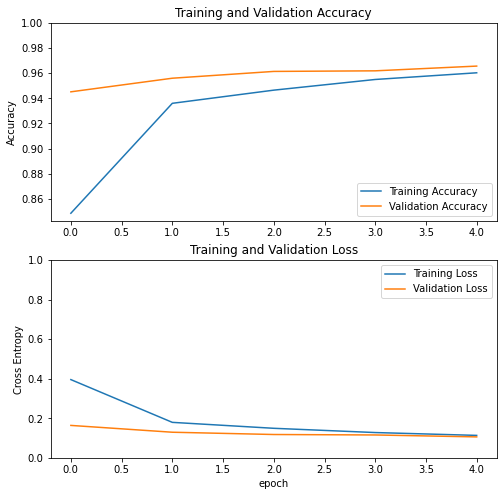

In [25]:


acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig(train_file_name)
plt.show()

In [18]:
# Confusion Matrix on Validation Data

# Generate predictions (probabilities)

predictions = model1.predict(val_generator, use_multiprocessing = False)

# Convert to an array of binary values
predictions = np.argmax(predictions, axis=1)

# Grab true labels from the validation generator
labels = val_generator.classes

# Generate confusion matrix

# labels = ['W', 'NW']
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html


conf_mat = confusion_matrix(labels, predictions, labels = [0, 1], sample_weight=None)
print(conf_mat)

85/85 [==============================] - 175s 2s/step
[[1969  160]
 [  17 2104]]


In [27]:
val_dat.groupby('race_category').count()

,id_num,picture_num,dob,doa,race,gender,facial_hair,age,age_diff,glasses,file_name,full_path
race_category,,,,,,,,,,,,
NW,2129,2129,2129,2129,2129,2129,0,2129,1586,0,2129,2129
W,2121,2121,2121,2121,2121,2121,0,2121,1570,0,2121,2121


In [28]:
# Verify that the class indices match the numbers of each class match the axes on the confusion matrix plot below

val_generator.class_indices

{'NW': 0, 'W': 1}

In [29]:
print(predictions)

[0 0 1 ... 1 1 0]


Normalized confusion matrix
[[0.92 0.08]
 [0.01 0.99]]


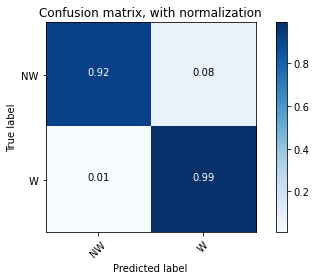

In [19]:
import itertools

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['NW','W'],
                      title='Confusion matrix, with normalization', normalize = True)
plt.savefig(cm_file_name)

In [20]:

# Remember Dictionary: {'NW': 0, 'W': 1}

#prf = precision_recall_fscore_support(labels, predictions, beta=1.0, labels=np.unique(labels), 
#                                pos_label=1, average=None)

report = classification_report(labels, predictions, target_names = ["NW", "W"], output_dict = False)

print(report)
type(report)


              precision    recall  f1-score   support

          NW       0.99      0.92      0.96      2129
           W       0.93      0.99      0.96      2121

    accuracy                           0.96      4250
   macro avg       0.96      0.96      0.96      4250
weighted avg       0.96      0.96      0.96      4250



str

In [21]:
def get_classification_report(y_test, y_pred):
    '''Source: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format'''
    report = classification_report(y_test, y_pred,  target_names = ["NW", "W"], output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    #df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report

In [22]:
report = get_classification_report(labels, predictions)
print(report)
report.to_csv(csv_file_name, index=True)
print(f"Metrics were saved to: {csv_file_name}")

              precision    recall  f1-score      support
NW             0.991440  0.924847  0.956987  2129.000000
W              0.929329  0.991985  0.959635  2121.000000
accuracy       0.958353  0.958353  0.958353     0.958353
macro avg      0.960384  0.958416  0.958311  4250.000000
weighted avg   0.960443  0.958353  0.958308  4250.000000
Metrics were saved to: /home/ajpineda/algo_bias_models/metric_csv/met_morph_baseline_2022-09-27.csv


In [ ]:
import sklearn
print(sklearn.__version__)

In [ ]:
# To verify the save worked, re-load model and compare its predictions to the c

model_check = keras.models.load_model(mod_file_name)
if np.allclose(model_check.predict(val_generator), model_final.predict(val_generator)) == True:
    print("Matched")

In [ ]:
#from keras.uapineda91tils import plot_model
#import graphviz
#plot_model(model, to_file='feb_model.png')